# Machine Learning Assignment 2: Road Sign Classification

In [308]:
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [309]:
import os
import numpy as np
import pandas as pd

#Getting all class labels
data_folder_name = "trafficsigns_dataset"
shapes = os.listdir(data_folder_name)

types = []

#To be used as pd dataframe
data = []


# 1. Iterator for all shapes in the folder
# 2. For each shape, access it's folder and iterate for all of it's types
# 3. For each of the types exist images. Create an entry for each image, keeping track of it's shape and type.
# 4. Add the given entry to the data and loop until everything has been added to the data array.
# 5. Convert the data array into a pandas dataframe.

for current_shape in shapes:
    current_directory = os.path.join(data_folder_name, current_shape)
    shape_types = os.listdir(current_directory)
    
    for current_type in shape_types:
        current_shape_type_directory = os.path.join(current_directory, current_type)
        
        for images in os.listdir(current_shape_type_directory):
            current_image = os.path.join(current_shape_type_directory, images)
            entry = [current_image, current_shape, current_type]
            data.append(entry)
            
data = pd.DataFrame(data, columns = ['ImgPath', 'Shape', 'Type'])

In [310]:
data_shape = data['Shape'].unique()
data_type = data['Type'].unique()

print("-------------")

print("Shapes:")
for shape in data_shape:
    print("\t", shape)

print("-------------")
    
print("Types:")
for shape_type in data_type:
    print("\t", shape_type)
    
print("-------------")

-------------
Shapes:
	 diamond
	 hex
	 round
	 square
	 triangle
-------------
Types:
	 rightofway
	 stop
	 bicycle
	 limitedtraffic
	 noentry
	 noparking
	 roundabout
	 speed
	 trafficdirective
	 traveldirection
	 continue
	 crossing
	 laneend
	 parking
	 giveway
	 warning
-------------


In [311]:
# Split the dataset into training testing and validation data
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.25)
train_data, val_data = train_test_split(train_data, test_size = 0.25)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))
print("Total number of images: {}".format(train_data.shape[0] + val_data.shape[0] + test_data.shape[0]))

Train data : 2080, Val Data: 694, Test Data: 925
Total number of images: 3699


In [312]:
#Using a function to plot the curvature of the algorithm so we can determine how to adjust it for better accuracy later on

import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

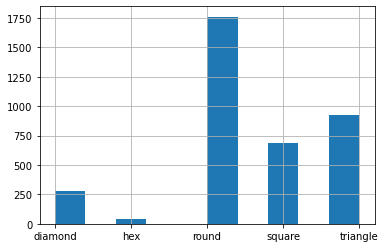

In [313]:
#Visualize number of values for each shape

data.Shape.hist()
plt.show()

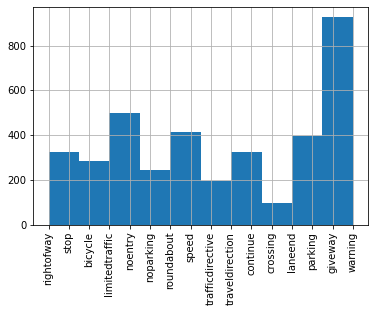

In [314]:
#Visualize number of values for each type

data.Type.hist()
plt.xticks(rotation='vertical')
plt.show()

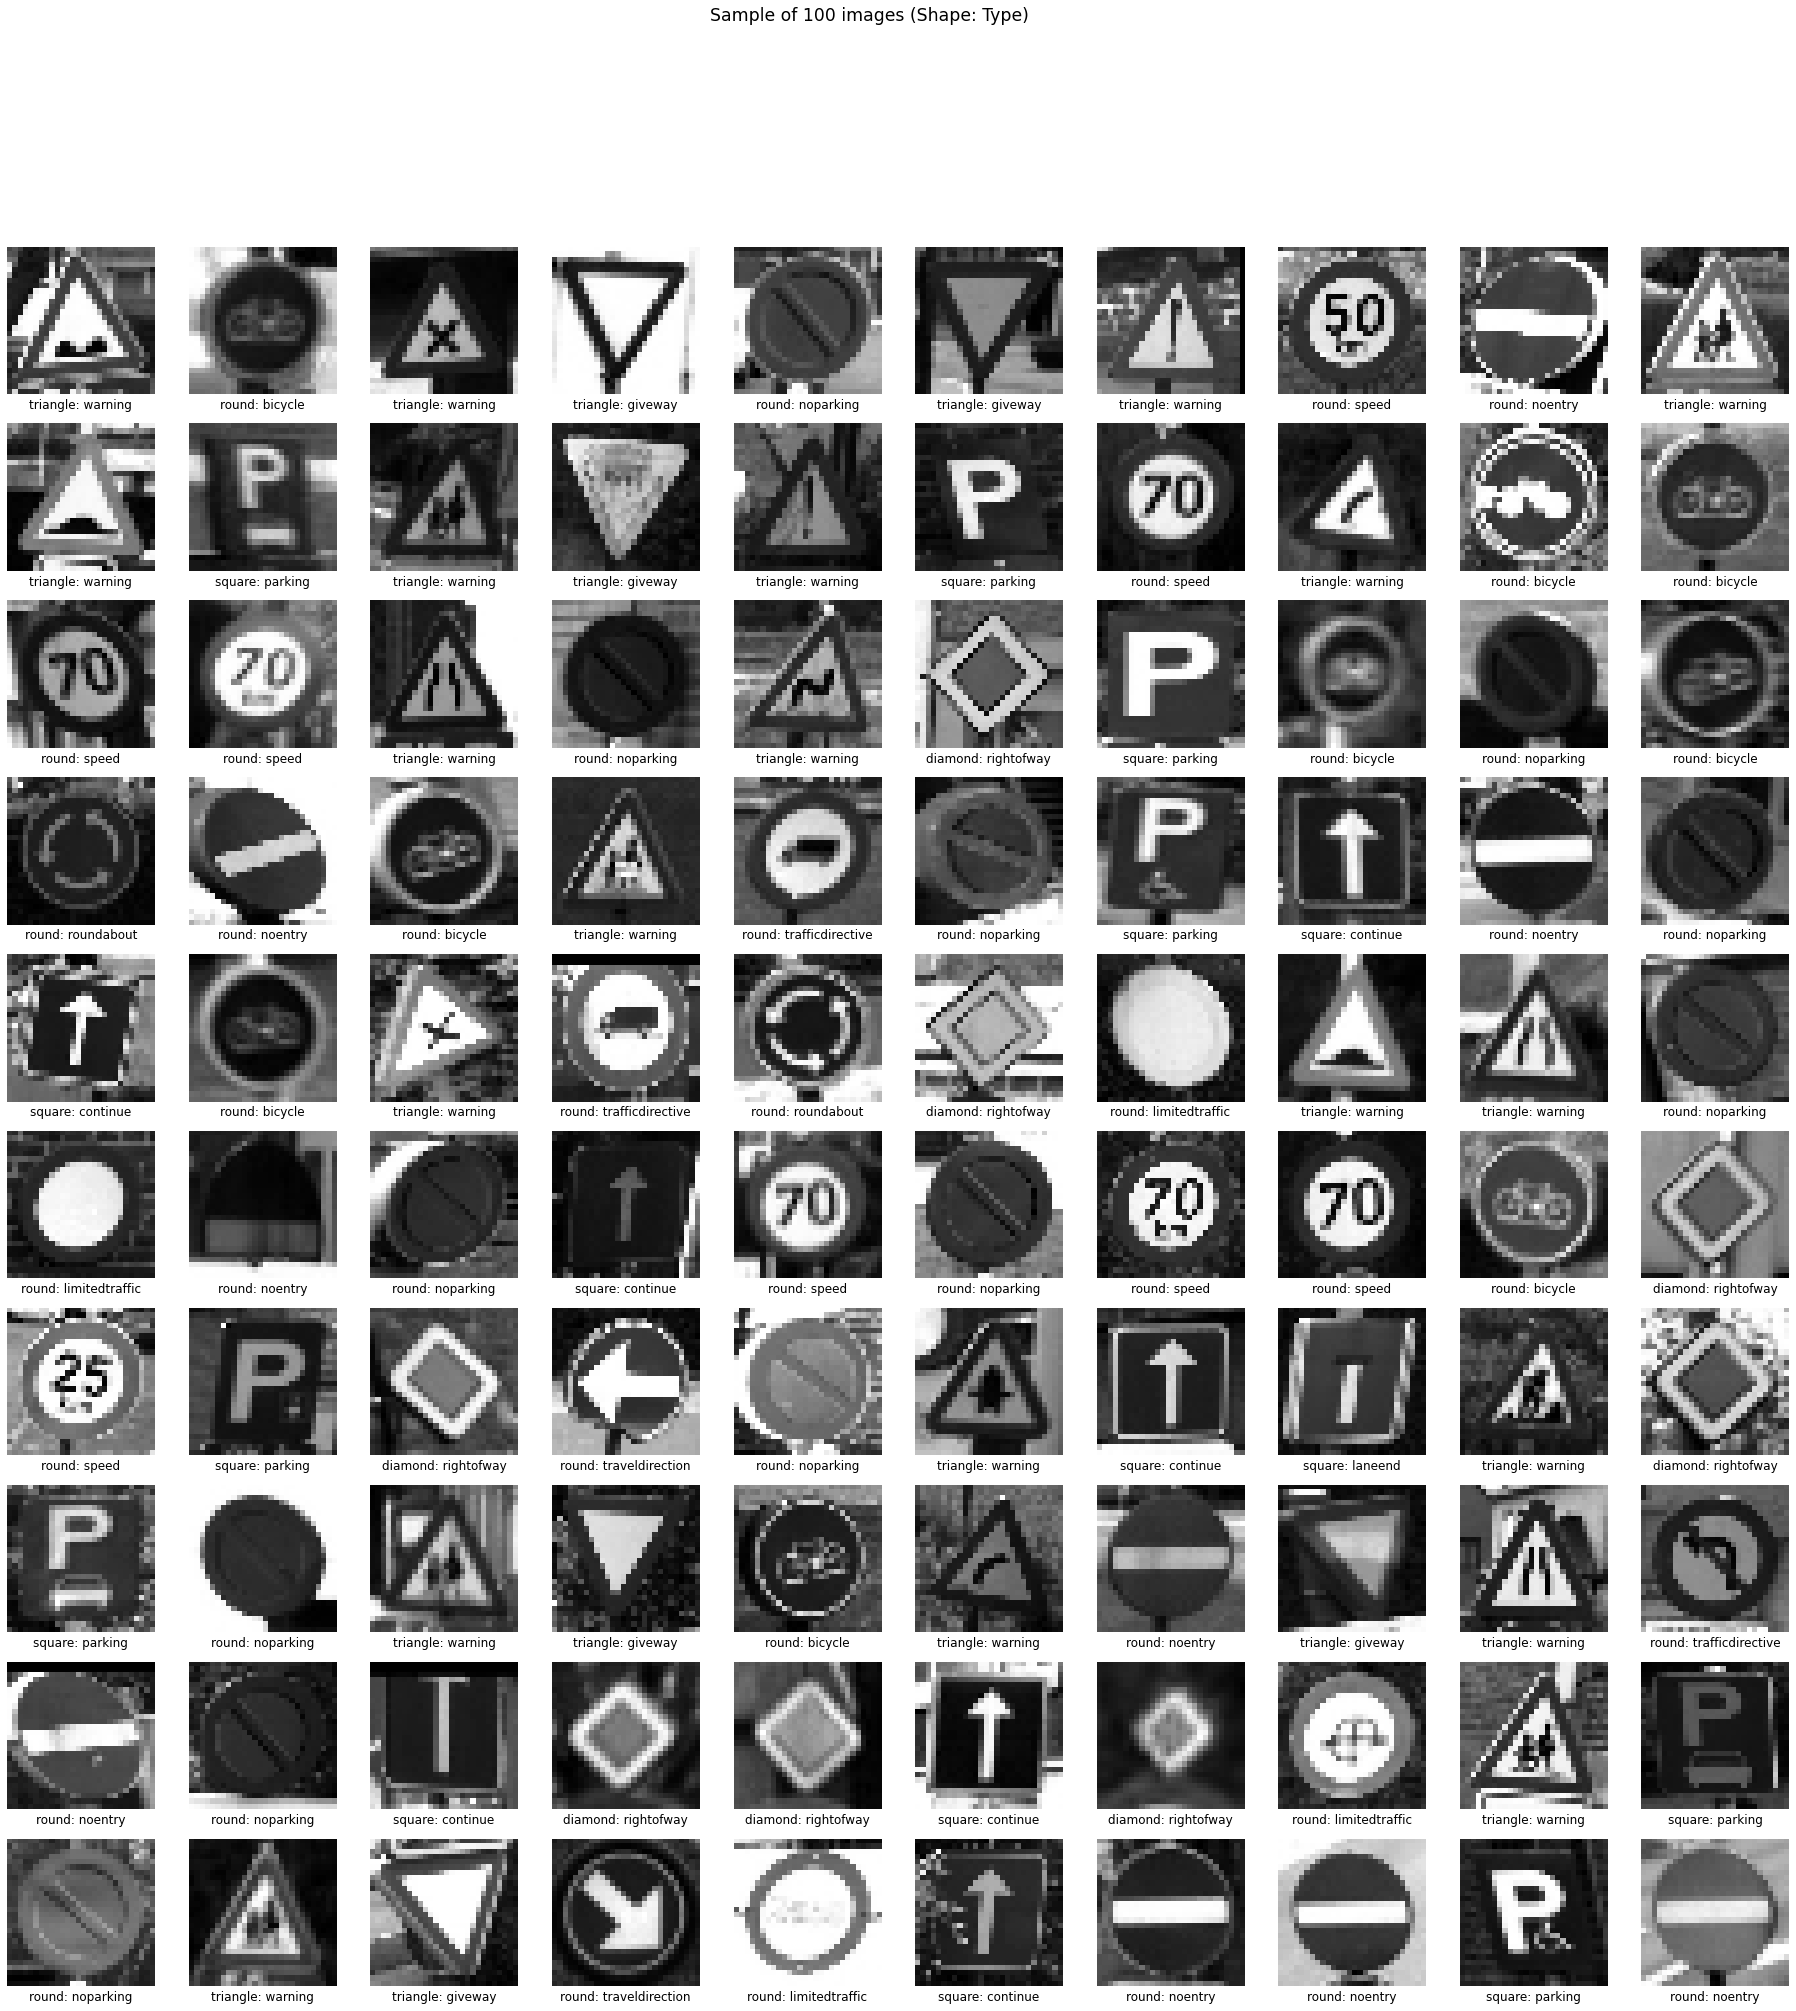

In [315]:
#Plotting Random images

from PIL import Image

r_inx = np.random.choice(data.shape[0], 100)
rand_data = data.loc[r_inx, 'ImgPath']

#Sampling of 100 random images
plt.figure(figsize=(32,32))
plt.suptitle("Sample of 100 images (Shape: Type)", ha='center', va='center', fontsize='xx-large')
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    ax1 = plt.subplot(10,10,i+1)
    ax1.imshow(im,cmap='gray')
    ax1.axis('off')
    ax1.text(0.5,-0.1, data['Shape'].iloc[r_inx[i]] + ": " +
                        data['Type'].iloc[r_inx[i]], size=12, ha="center", 
         transform=ax1.transAxes)

plt.show()

# DO

# EXPLORATORY

# DATA ANALYSIS

# ABOVE
***

In [316]:
#Mapping categorical values to numerics

d = {'diamond' : 0, 'round' : 1, 'hex' : 2, 'square' : 3, 'traignle' : 4}
data['Shape'] = data['Shape'].map(d, na_action='ignore')

In [317]:
# We will define some base parameters to use for the neural networks (as we are using multilayer perceptrons with a hidden layer)

#The input dimension is 28x28x3 as the given dataset consists of greyscale, 2d images where each has a resolution of 28x28
#pixels each.
INPUT_DIM = (28, 28, 3)

#Hidden layer is arbitrarily set to 128 for now, but will be tuned later
HIDDEN_LAYER_DIM = 256

# The output classes will firstly be limited to 5 to test the neural network in detecting a given sign's shape
OUTPUT_CLASSES = 5

In [318]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.9.0'

In [346]:
#Using the sequential API, we will define the layers of the neural network.

# from tensorflow.keras import Sequential
# from tensorflow.keras import layers

# shape_model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=INPUT_DIM),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES)
# ])

shape_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)])

ValueError: Input 0 of layer "conv2d_30" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 2352)

In [344]:
#Compilation of the model

shape_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [345]:
shape_model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 64)        

In [322]:
#Actually training the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load images via dataframe using the flow_from_dataframe keras function

train_data['Shape'] = train_data['Shape'].astype('str')
val_data['Shape'] = val_data['Shape'].astype('str')

train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2080 validated image filenames belonging to 5 classes.
Found 694 validated image filenames belonging to 5 classes.


In [323]:
# Train the model

history = shape_model.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=50, 
                                    verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_5076/1391913924.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = shape_model.fit_generator(train_generator,


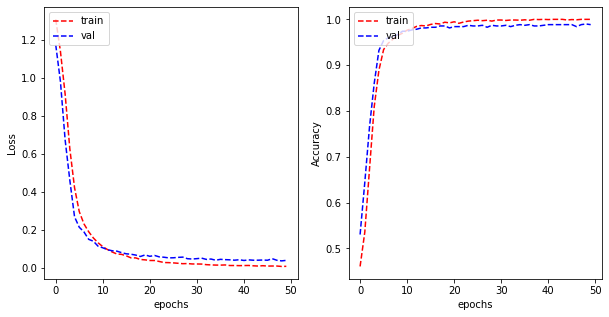

In [324]:
# Graph the loss and accuracy 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

THe loss function is relatively strong (1.00 - 1.25 range) whileas accuracy can be worked on. Both the training and validation accuracy sit in the 0.55-0.60 range, which can be improved on. Likewise, the validation data's accuracy fluctuates considerably, which similarly can be tuned to have a lower displacement between training and validation accuracy.

In [325]:
#This function adds ridge penalty (variables with minor contribution to outcome are close to 0)

reg_lambda = 0.01

shape_model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', 
    kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [326]:
shape_model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [327]:
history_reg = shape_model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_5076/3641511967.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = shape_model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


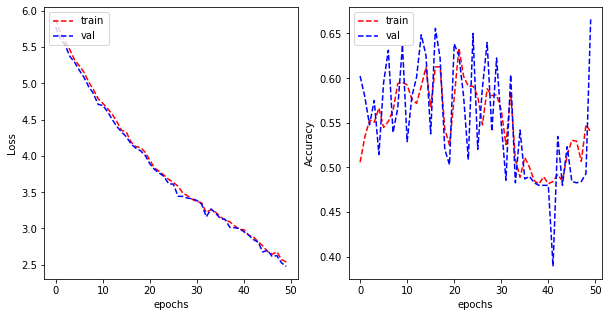

In [328]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [329]:
#Dropout to reduce overfitting and compare if it results in a better model than just the regularized model (as the regularized
#model is already fairly good)

reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [330]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [331]:
history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_5076/243628706.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


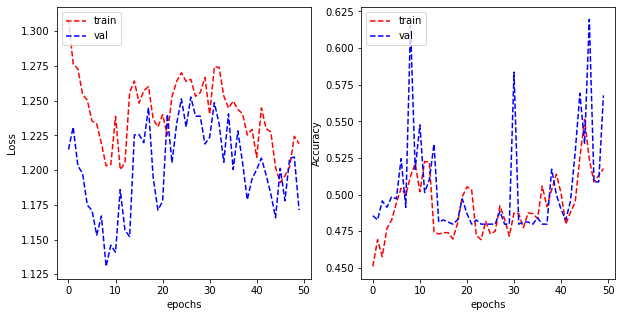

In [332]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [333]:
#Now trying on both a Dropped and Regularized model
reg_lambda = 0.01

shape_model_reg_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', 
    kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [334]:
shape_model_reg_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [335]:
history_reg_drop = shape_model_reg_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_5076/84197709.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg_drop = shape_model_reg_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


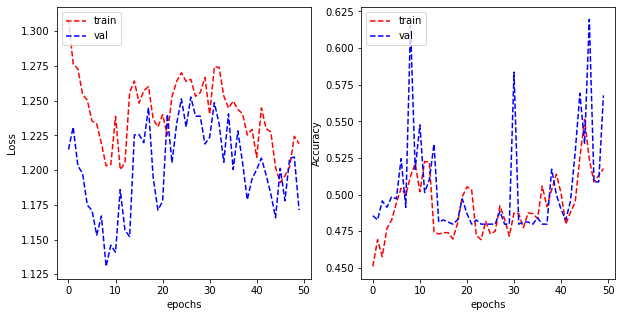

In [336]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

Values appear to be no different from the dropped model.

In [337]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')



Found 925 validated image filenames belonging to 5 classes.


In [338]:
shape_model.evaluate(test_generator)

925/925 [==============================] - 5s 5ms/step - loss: 0.0298 - categorical_accuracy: 0.9903


[0.029773153364658356, 0.9902702569961548]

1/1 [==============================] - 0s 58ms/step
This image most likely belongs to triangle.
1/1 [==============================] - 0s 13ms/step
This image most likely belongs to square.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to round.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to hex.
1/1 [==============================] - 0s 14ms/step


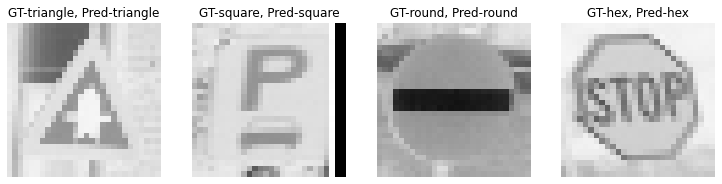

In [339]:
label_names = {'diamond' : 0, 'hex' : 1, 'round' : 2, 'square' : 3, 'triangle' : 4}

d_inv = {v: k for k, v in label_names.items()}

plt.figure(figsize=(16,4))
batches = 0

for x,y in test_generator:
    # print(x)
    # print(y)
    batches = batches + 1
    y_hat = shape_model.predict(x)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5,batches)
        plt.imshow((x * 255).astype(np.uint8))
        plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
        print(
            "This image most likely belongs to {}."
            .format(d_inv[np.argmax(y_hat[0])])
        )
    else:
        break
    
    plt.axis('off')

In [340]:
shape_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, None, None, 64) 